In [ ]:
import gymnasium
import torch
import os
import numpy as np
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from datetime import date, datetime
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from src import helpers
import importlib



In [2]:
n_envs = 7
start_time_suffix = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/monitor_{start_time_suffix}/"


print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"MuJoCo version: {mujoco.__version__}")

PyTorch CUDA available: True
MuJoCo version: 3.4.0


# MuJoCo Native Training Setup (CPU Optimized)
Using native MuJoCo simulation with vectorized environments for maximum CPU throughput.


In [3]:
# Setup paths
project_root = r"C:\GitHub\training-lucy"
xml_path = os.path.join(project_root, "animals", "ant.xml")

# Verify model loads correctly
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Model loaded: {model.nq} DOFs, {model.nu} actuators")

Model loaded: 15 DOFs, 8 actuators


In [ ]:
vec_env = make_vec_env(
    "Ant-v5",
    n_envs=n_envs,
    env_kwargs={"xml_file": xml_path},
    vec_env_cls=SubprocVecEnv,
    monitor_dir=log_dir,
)

print(f"Created {n_envs} parallel environments")

Created 7 parallel environments


In [ ]:
vec_env = VecMonitor(vec_env, log_dir)



# CPU-optimized PPO configuration
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",  # Force CPU
    n_steps=2048,
    batch_size=256,  # Smaller batch for CPU
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    learning_rate=3e-4,
)

# Train with callback to track progress
callback = TrainingCallback()
model.learn(total_timesteps=1_000_000)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | -110     |
| time/              |          |
|    fps             | 4924     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 121         |
|    ep_rew_mean          | -128        |
| time/                   |             |
|    fps                  | 3924        |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009460406 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -0.00933    |
|    learning

- model trains well after 4 million timestamps

In [ ]:
df = load_results(log_dir)
df

,index,r,l,t
0,0,2.242930,12,79.229305
1,0,2.242930,12,79.229914
2,0,-18.461907,15,79.234006
3,1,-18.461906,15,79.234631
4,0,-34.662744,28,79.253262
...,...,...,...,...
23445,11722,23.901556,85,339.468068
23446,1706,103.510689,151,339.573721
23447,11723,103.510730,151,339.574126
23448,1707,36.615364,88,339.678964


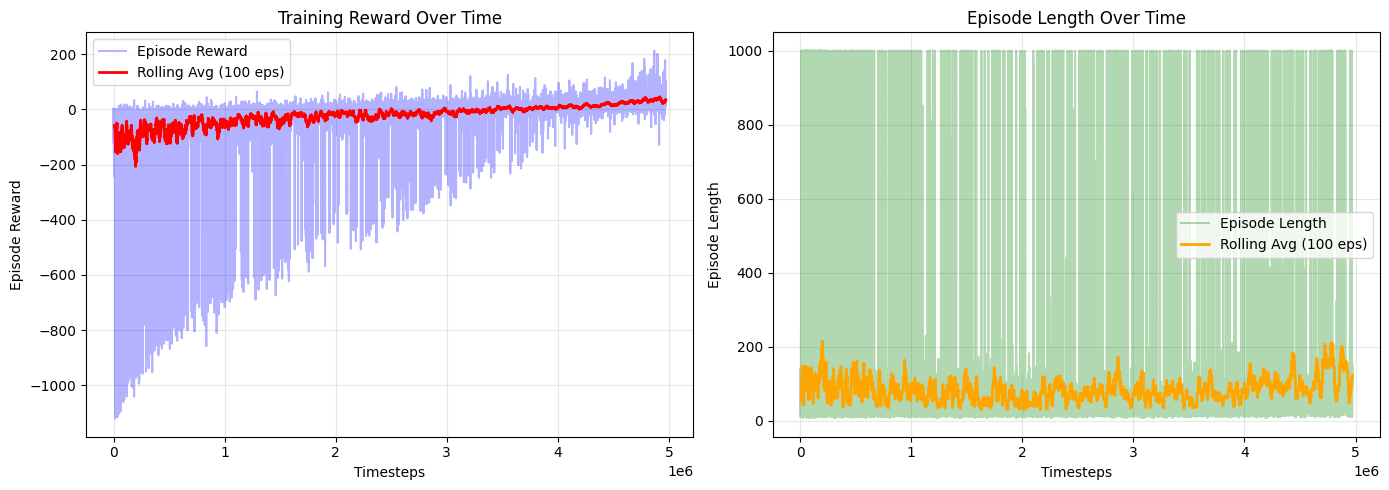

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Training Reward Over Time'}, xlabel='Timesteps', ylabel='Episode Reward'>,
        <Axes: title={'center': 'Episode Length Over Time'}, xlabel='Timesteps', ylabel='Episode Length'>],
       dtype=object))

In [ ]:
importlib.reload(helpers)

helpers.plot_training_progress(df)

In [ ]:
# Save trained model


model.save(os.path.join(project_root, "trained_models", f"ppo_ant_{start_time_suffix}"))
vec_env.close()
print(f"Model saved to trained_models/ppo_ant_{start_time_suffix}")

: 

: 

In [ ]:
break

: 

: 

In [ ]:
# Evaluate trained model
eval_env = gymnasium.make("Ant-v5", xml_file=xml_path, render_mode="human")
model = PPO.load(os.path.join(project_root, "trained_models", "ppo_ant"))

obs, info = eval_env.reset()
while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    if terminated or truncated:
        obs, info = eval_env.reset()

: 

: 